In [1]:
import sys
import os
sys.path.append("../")


In [2]:
from tqdm import tqdm
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.env.robomimic.robomimic_lowdim_wrapper import RobomimicLowdimWrapper
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils

In [3]:
def create_env(env_meta, obs_keys):
    ObsUtils.initialize_obs_modality_mapping_from_dict(
        {'low_dim': obs_keys})
    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=False,
        use_image_obs=False, 
    )
    return env

In [4]:
def create_disturbance_function(task_name):
    if task_name == "lift":
        def disturbance_function(object_pos_quat, speed):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    elif task_name == "square":
        def disturbance_function(object_pos_quat):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    else:
        raise ValueError(f"Invalid task name: {task_name}")
    
    return disturbance_function

In [5]:
task_name = "lift"
# task_name = "square"
dataset_type = "ph"
dataset_path = f"../data/robomimic/datasets/{task_name}/{dataset_type}/low_dim_abs.hdf5"
dataset_path = os.path.expanduser(dataset_path)
env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path)

#Inlucde this since it is abs true
obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
env_meta['env_kwargs']['controller_configs']['control_delta'] = False
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

robomimic_env = create_env(
                    env_meta=env_meta, 
                    obs_keys=obs_keys
                )

disturance_function = create_disturbance_function(task_name)

render_hw = (128, 128)
env_n_obs_steps = 2
env_n_action_steps = 8
max_steps = 400
render_camera_name = 'agentview'
multistep_env = MultiStepWrapper(
                    RobomimicLowdimWrapper(
                        env=robomimic_env,
                        obs_keys=obs_keys,
                        init_state=None,
                        render_hw=render_hw,
                        render_camera_name=render_camera_name
                    ),
                    n_obs_steps=env_n_obs_steps,
                    n_action_steps=env_n_action_steps,
                    max_episode_steps=max_steps
                )

Created environment with name Lift
Action size is 7


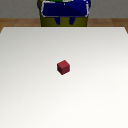

In [6]:
obs = multistep_env.reset()
state = multistep_env.env.env.get_state()

frame = multistep_env.render(mode='rgb_array')
img = Image.fromarray(frame)
img.show()

object_pos_quat = state['states'][10:17] # x, y, z, qx, qy, qz, qw
robot0_gripper_qpos = state['states'][8:10]
robot_q_pos = state['states'][1:8]

In [8]:
print(object_pos_quat)

[ 0.00414678 -0.00269443  0.83188574  0.95421144  0.          0.
  0.29913295]


In [7]:
multistep_env.env.env.get_observation()

{'object': array([ 0.00414678, -0.00269443,  0.83188574,  0.        ,  0.        ,
         0.29913295,  0.95421144, -0.12693415,  0.00648964,  0.15970938]),
 'robot0_eef_pos': array([-0.12278738,  0.00379521,  0.99159512]),
 'robot0_eef_quat': array([0.99937535, 0.01105507, 0.03347056, 0.00253339]),
 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}

In [ ]:
# object_pos_lst = list()

# for i in tqdm(range(100)):
#     multistep_env.reset()
#     state = multistep_env.env.env.get_state()
#     object_pos_quat = state['states'][10:13]
#     object_pos_lst.append(object_pos_quat)

# object_pos_lst = np.array(object_pos_lst)
# print(object_pos_lst.shape)



[ 0.020833 -0.020833]


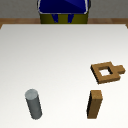

In [ ]:
new_state = deepcopy(state)
new_object_pos_quat = object_pos_quat + np.array([0., 0.0, 0.0, 0, 0, 0, 0])
new_state['states'][10:17] = new_object_pos_quat
multistep_env.env.env.reset_to(new_state)
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
frame = multistep_env.render(mode='rgb_array')
img = Image.fromarray(frame)
img.show()


[ 0.03795917 -0.02719653]


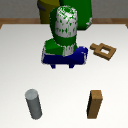

In [11]:
multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


[ 0.03766376 -0.02817823]
[ 0.03766376 -0.02817823]


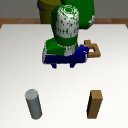

In [12]:
obs, reward, doen, info = multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
new_state = {k:v for k,v in deepcopy(state).items() if k != 'model'}
new_state['states'][10:17] = object_pos_quat + np.array([0.000, 0.0, 0.0, 0, 0, 0, 0])
multistep_env.env.env.reset_to(new_state)
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


In [24]:
print(new_state.keys())

dict_keys(['model', 'states'])


In [16]:
state['states']

array([ 3.00000000e-01,  2.21017089e-02,  8.69597692e-01, -2.26376387e-02,
       -2.03279614e+00, -1.26152978e-01,  2.87523311e+00,  8.22526585e-01,
        3.76637621e-02, -2.81782277e-02, -1.11230565e-01,  1.33610410e-01,
        8.34968280e-01, -4.71310116e-02, -1.98377027e-04, -9.36011186e-06,
        9.98888697e-01,  1.00000242e+01,  1.00000000e+01,  9.58056057e+00,
        9.99998903e-01,  0.00000000e+00,  1.48128844e-03,  0.00000000e+00,
       -2.02164735e-01, -2.16173924e-01,  2.03257405e-01,  6.65735736e-01,
       -2.45815670e-01, -2.13360720e+00, -2.36358872e-01,  1.54621112e-02,
       -1.98777317e-02,  2.34085614e-05,  2.21392202e-06, -1.32179457e+00,
       -6.93034459e-19,  1.05319164e-02,  6.56778759e-20,  4.85680824e-04,
        0.00000000e+00, -2.63108096e+00,  0.00000000e+00,  2.19282808e-02,
        0.00000000e+00])

In [20]:
multistep_env.reset()
print(multistep_env.env.env.get_observation())
print(multistep_env.env.env.get_state()['states'])

{'object': array([-0.11477313,  0.18939993,  0.89      ,  0.        ,  0.        ,
        0.75675045,  0.65370387, -0.05184033, -0.20347065,  0.12818963,
       -0.65669119,  0.74830133, -0.05795358,  0.07377842]), 'robot0_eef_pos': array([-0.08479188, -0.01226325,  1.02767134]), 'robot0_eef_quat': array([0.99555891, 0.00778386, 0.09371633, 0.00437285]), 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}
[ 0.00000000e+00 -1.98657427e-02  1.80270837e-01 -6.31189442e-03
 -2.59950683e+00 -7.32038797e-03  2.96766726e+00  7.51375803e-01
  2.08330000e-02 -2.08330000e-02 -1.14773126e-01  1.89399930e-01
  8.90000000e-01  6.53703872e-01  0.00000000e+00  0.00000000e+00
  7.56750453e-01  1.00000000e+01  1.00000000e+01  1.00000000e+01
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0

In [15]:
print(obs.shape)

(2, 23)


In [28]:
"Nut" in str(type(multistep_env.env.env.env))

True

In [25]:
rewards = multistep_env.env.env.env.staged_rewards()
print(rewards)

(0.0005763066276480933, 0.0, 0.0, 0.00032211476627157503)
